In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import sys

def print_fl(output):
    print(output)
    sys.stdout.flush()

#import warnings
#warnings.simplefilter("error")

In [2]:
class PERMSimulation:
    n = 0
    r = None
    max_size = 250
    n_dim = 2
    epsilon = 0.25
    sigma = 0.8
    T = 1.0
    d = 1.0
    n_theta = 6
    alpha_lo = 1.2
    # alpha_hi = 1.8
    pol_weight_renormalization = 1/(0.75*6) # renormalization factor recommended by the book
    target_population = 0
    
    capital_Ws = None
    bead_energies = None
    pol_weights = None
    
    iteration = 0
    
    results_r_e2e = None
    results_r_gyration = None
    results_pol_weights = None
    
    def initialise(self, nIn, targetIn):
        self.n = nIn
        self.target_population = targetIn
        self.r = np.zeros((self.n, self.max_size, self.n_dim))
        self.capital_Ws = np.zeros((self.n, self.max_size))
        self.bead_energies = np.zeros((self.n, self.max_size))
        self.pol_weights = np.zeros((self.n, self.max_size))
        
        self.results_r_e2e = np.zeros((self.n, self.max_size))
        self.results_r_gyration = np.zeros((self.n, self.max_size))
        self.results_pol_weights = np.zeros((self.n, self.max_size))
        
        # initialise second bead at (d,0-) for all polymers
        self.r[:,1,0] = self.d
        self.iteration = 1
        self.pol_weights[:,0:3] = 1.0
        
        self.calculate_results()
        
    # calculate LJ-potential energy
    def V_LJ(self, sq_dist):
        # note that we expect squared distances to be input, so the r^12 and r^6 terms translate to r_sq^6 and r_sq^3 terms
        return 4*self.epsilon*( (self.sigma / sq_dist)**6 - (self.sigma / sq_dist)**3 )
        #return np.zeros_like(sq_dist)
    
    # add the next bead to the entire current population
    def add_beads(self):
        # the following code is 2d-specific and needs to be adjusted if the dimensionality is changed
        angle_offsets = np.random.sample((self.n,1)) * (2*np.pi) / self.n_theta
        candidate_angles = np.tile(np.linspace(0, 2*np.pi, self.n_theta, endpoint=False), (self.n, 1)) + angle_offsets
        
        candidate_dr = np.zeros((self.n, self.n_theta, self.n_dim)) 
        candidate_dr[:,:,0] = self.d * np.cos(candidate_angles)
        candidate_dr[:,:,1] = self.d * np.sin(candidate_angles)
        
        candidate_r = candidate_dr + self.r[:,self.iteration,np.newaxis,:] 
        theta_energies = np.zeros((self.n, self.n_theta))
        
        for i in range(0, self.n):
            # squared euclidean is probably faster, and we'll square it anyway in the LJ calculation
            sq_distances = scipy.spatial.distance.cdist(candidate_r[i,:,:], self.r[i,0:self.iteration+1,:], 'sqeuclidean')
            lj_potentials = self.V_LJ(sq_distances)
            theta_energies[i,:] = np.sum(lj_potentials, axis = 1)
            
        # we scale nans to zero in the following section; if probabilities get too low the polymer gets pruned anyway
        theta_boltzmann = np.nan_to_num(np.exp(- theta_energies / self.T))
        self.capital_Ws[:,self.iteration] = np.sum(theta_boltzmann, axis = 1)        
        theta_probabilities = np.nan_to_num(theta_boltzmann / self.capital_Ws[:,self.iteration,np.newaxis])
        
        # do a roulette wheel selection of theta's
        selection_thresholds = np.random.sample((self.n,1))
        roulette_wheel = selection_thresholds - np.cumsum(theta_probabilities, axis = 1)
        # the argmax function is guaranteed to return the first occurrence of the maximum (see docs)
        # it also uses C-level loop so it is nice 'n fast
        selected_thetas = np.argmax(roulette_wheel < 0, axis = 1)
        
        # add the new beads to the population and update polymer weights
        self.r[:,self.iteration+1,:] = candidate_r[np.arange(self.n), selected_thetas, :]
        self.bead_energies[:,self.iteration+1] = theta_energies[np.arange(self.n),selected_thetas]
        
        #if self.iteration > 1:
        self.pol_weights[:,self.iteration+1] = self.pol_weights[:,self.iteration] * self.capital_Ws[:,self.iteration] * self.pol_weight_renormalization
        
        self.iteration += 1
        
    def delete_polymers(self, idx):
        self.r = np.delete(self.r, idx, axis=0)
        self.capital_Ws = np.delete(self.capital_Ws, idx, axis=0)
        self.bead_energies = np.delete(self.bead_energies, idx, axis=0)
        self.pol_weights = np.delete(self.pol_weights, idx, axis=0)
        
    def copy_polymers(self, idx):
        self.r = np.append(self.r, self.r[idx], axis=0)
        self.capital_Ws = np.append(self.capital_Ws, self.capital_Ws[idx], axis=0)
        self.bead_energies = np.append(self.bead_energies, self.bead_energies[idx], axis=0)
        self.pol_weights = np.append(self.pol_weights, self.pol_weights[idx], axis=0)
        
    def move_polymers(self, idxFrom, idxTo):
        self.r[idxTo,:,:] = self.r[idxFrom,:,:]
        self.capital_Ws[idxTo,:] = self.capital_Ws[idxFrom,:]
        self.bead_energies[idxTo,:] = self.bead_energies[idxFrom,:]
        self.pol_weights[idxTo,:] = self.pol_weights[idxFrom,:]
        
    def calculate_results(self):
        self.results_pol_weights[:,self.iteration] = self.pol_weights[:,self.iteration]
        self.results_r_e2e[:,self.iteration] = np.linalg.norm(self.r[:,self.iteration,:], axis = 1)
        
        r_means = np.mean(self.r[:,0:(self.iteration + 1),:], axis=1)
        dr_sqs = (self.r[:,0:(self.iteration + 1),:] - r_means[:,np.newaxis,:])**2
        self.results_r_gyration[:,self.iteration] = np.sqrt(1/(self.iteration + 1) * np.sum(dr_sqs,axis=(1,2)))
        
    def prune_enrich(self):
        average_weight = np.mean(self.pol_weights[:,self.iteration])
        # average_weight_at_3 = np.mean(self.pol_weights[:,2])
        
        #self.alpha_hi = 2 ** (np.math.log(self.n,10)-2)
        #self.alpha_lo = 1.5 ** (np.math.log(self.n,10)-1)
        
        # select the polymers eligible for pruning
        # calculate weights relative to the weight at length 3 as recommended by the book
        prune_limits = self.alpha_lo * average_weight / self.pol_weights[:,2]
        
        # select p/e limits using the target population size
        #sorted_weights = np.sort(self.pol_weights[:,self.iteration])
        #sorted_weights = sorted_weights[sorted_weights > 0.0]
        #pop_diff = self.n - self.target_population
        #if pop_diff > 0:
        #    prune_limits = sorted_weights[int(pop_diff*1.5)]
        #    enrich_limits = sorted_weights[-int(pop_diff / 8)]
        #else:
        #    prune_limits = 0.0
        #    enrich_limits = sorted_weights[int(pop_diff)]
        
        prune_candidates = np.ravel(np.where(self.pol_weights[:,self.iteration] < prune_limits))
        prune_candidates = prune_candidates[0:int(self.n/4)] # prune at most one quarter of the population
        prune_actions = np.random.sample(prune_candidates.shape) < 0.5
        prune_deletions = prune_candidates[prune_actions == True]
        prune_survivors = prune_candidates[prune_actions == False]

        # double the weights of the polymers that survive pruning
        self.pol_weights[prune_survivors] *= 2
        # delete the prune candidates marked for deletion
        #we do moving of the polymers now!
        # self.delete_polymers(prune_deletions)
        
        pruned = np.size(prune_deletions)

        # select the polymers eligible for enriching
        #enrich_limits = self.alpha_hi * average_weight / self.pol_weights[:,2]
        # make sure we enrich as many polymers as we prune
        sorted_weights = np.argsort(self.pol_weights[:,self.iteration])
        #print(sorted_weights.shape)
        #enrich_limits = sorted_weights[-pruned]
        
        #enrich_candidates = np.ravel(np.where(self.pol_weights[:,self.iteration] >= enrich_limits))
        enrich_candidates = sorted_weights[-pruned:]
        
        self.pol_weights[enrich_candidates,self.iteration] *= 0.5
        
        self.move_polymers(enrich_candidates, prune_deletions)
        
        #we do moving of the polymers now!
        #self.copy_polymers(enrich_candidates)
        
        enriched = np.size(enrich_candidates)

        self.n += enriched - pruned
        assert self.n == self.r.shape[0]
        
        return pruned, enriched, average_weight
        
    def run_simulation(self):
        while(self.iteration < self.max_size - 1):
            # add a new bead across the population
            self.add_beads()
            self.calculate_results()
            
            # do pruning-enrichment magic
            deleted, enriched, average_weight = self.prune_enrich()
            
            print_fl("I: %d\t n: %d\t p: %d\t e: %d\t w: %e" % (self.iteration, self.n, deleted, enriched, average_weight))

In [3]:
testSim = PERMSimulation()

testSim.initialise(10000,10000)
%time testSim.run_simulation()

I: 2	 n: 10000	 p: 1245	 e: 1245	 w: 1.311459e+00
I: 3	 n: 10000	 p: 1225	 e: 1225	 w: 1.619905e+00
I: 4	 n: 10000	 p: 1273	 e: 1273	 w: 1.960812e+00
I: 5	 n: 10000	 p: 842	 e: 842	 w: 2.329504e+00
I: 6	 n: 10000	 p: 569	 e: 569	 w: 2.760775e+00
I: 7	 n: 10000	 p: 519	 e: 519	 w: 3.269651e+00


/Users/jesse/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in true_divide


I: 8	 n: 10000	 p: 530	 e: 530	 w: 3.845544e+00
I: 9	 n: 10000	 p: 492	 e: 492	 w: 4.488602e+00
I: 10	 n: 10000	 p: 444	 e: 444	 w: 5.238810e+00
I: 11	 n: 10000	 p: 416	 e: 416	 w: 6.100418e+00
I: 12	 n: 10000	 p: 417	 e: 417	 w: 7.132073e+00
I: 13	 n: 10000	 p: 383	 e: 383	 w: 8.259444e+00
I: 14	 n: 10000	 p: 407	 e: 407	 w: 9.577111e+00
I: 15	 n: 10000	 p: 385	 e: 385	 w: 1.111262e+01
I: 16	 n: 10000	 p: 386	 e: 386	 w: 1.288502e+01
I: 17	 n: 10000	 p: 388	 e: 388	 w: 1.487491e+01
I: 18	 n: 10000	 p: 385	 e: 385	 w: 1.714731e+01
I: 19	 n: 10000	 p: 388	 e: 388	 w: 1.966447e+01
I: 20	 n: 10000	 p: 393	 e: 393	 w: 2.266285e+01
I: 21	 n: 10000	 p: 382	 e: 382	 w: 2.610084e+01
I: 22	 n: 10000	 p: 374	 e: 374	 w: 3.001438e+01
I: 23	 n: 10000	 p: 400	 e: 400	 w: 3.450797e+01
I: 24	 n: 10000	 p: 393	 e: 393	 w: 3.965344e+01
I: 25	 n: 10000	 p: 387	 e: 387	 w: 4.562893e+01
I: 26	 n: 10000	 p: 391	 e: 391	 w: 5.226620e+01
I: 27	 n: 10000	 p: 350	 e: 350	 w: 6.025589e+01
I: 28	 n: 10000	 p: 37

(250,)
[ 0.7389906  -0.14854978]


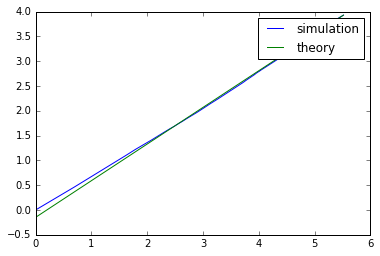

In [14]:
r_e2e = np.mean(testSim.results_r_e2e, axis=0)
print(r_e2e.shape)
lengths = np.arange(0,np.size(r_e2e))
x = np.log(lengths[1:])
y = np.log(r_e2e[1:])
p = np.polyfit(x, y, 1)
print(p)

plt.plot(x, y, label="simulation")
plt.plot(x, p[0]*x + p[1], label="theory")
plt.legend()
_, xmax = plt.xlim()
plt.xlim([0, xmax])
plt.show()


In [11]:
xmax

6.0

In [ ]:
plt.plot(testSim.r[:,:,0], testSim.r[:,:,1])
plt.show()

In [ ]:
i = 8

plt.plot(testSim.r[i,:,0], testSim.r[i,:,1])
plt.show()

In [ ]:
testSim.pol_weights.shape[0]